### Imports:

In [3]:
import numpy as np
import matplotlib.pyplot as plt

g = 9.81  #Gravitational acceleration (m/s^2)

## A] Kalman Filter Implementation for Parabolic throw

Task: Estimate the position and velocity vector of the ball only from the observed erroneous positions
over time.

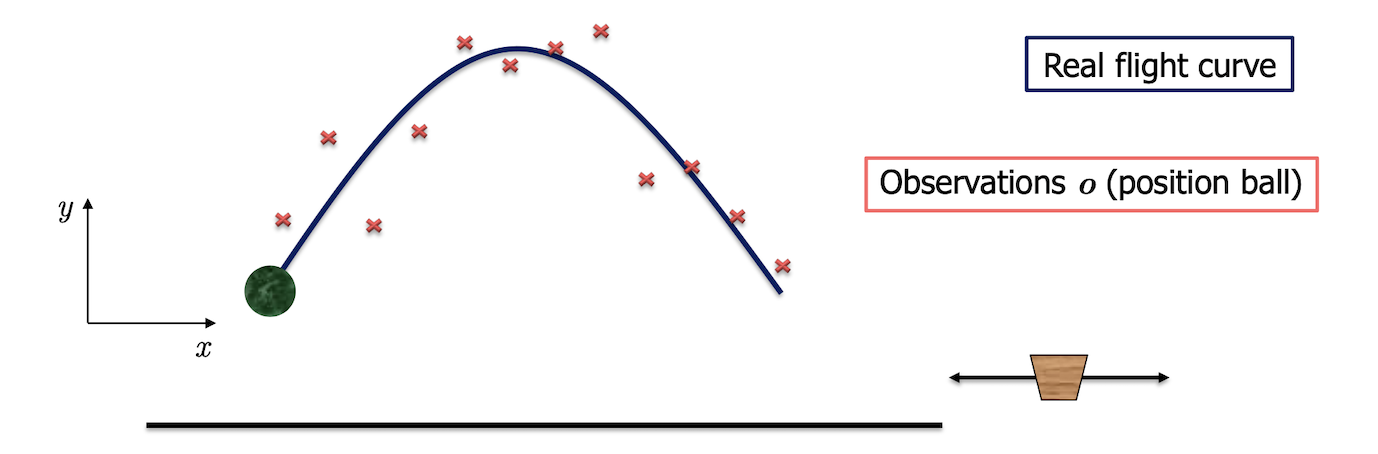

### True Trajectory:

This function calculates the true trajectory of the ball.

Function Parameters:
- initial_position: [x,y] co-ordinates of ball's initial position
- v0 (float): launch speed (m/s)
- theta (float): launch angle (radians)
- dt (float): time step (seconds)
- total_time (float): total simulation time (seconds)
    
Returns:
- t (np.ndarray): time steps
- true_positions (np.ndarray): true positions (x, y)

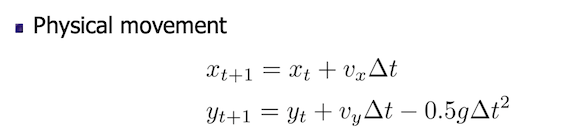

In [4]:
def simulate_trajectory(initial_position, v0, theta, dt, total_time):

    num_steps = int(total_time / dt)
    trajectory = np.zeros((num_steps, 4))
    time_steps = []
    
    vx = v0 * np.cos(np.radians(theta))
    vy = v0 * np.sin(np.radians(theta))
    
    x, y = initial_position[0], initial_position[1]
    
    for t in range(num_steps):
        time_steps.append(t*dt)
        trajectory[t] = [x, y, vx, vy]
        x = x + vx * dt
        y = y + vy * dt - 0.5 * g * dt ** 2
        vy = vy - g * dt
         
    return np.array(time_steps), trajectory

### Simulate Observations:

This function simulates the sensor observations to be used in Kalman Filter for finding estimates.

Parameters:
- true_positions (np.ndarray): true positions (x, y)
- observation_noise_std (float): standard deviation of the observation noise
- blank_ranges (numply list) : List of time ranges where the observations need to be dropped out
- dropout_probability (float): fraction of observations that are dropped out from the given ranges
    
Returns:
- observed_time_points (np.ndarray): Time points where observations are made
- observed_positions (np.ndarray): observed positions with noise

In [5]:
def simulate_observations(true_trajectory, observation_noise_std, dropout_probability, blank_ranges):
 
    time_points = true_trajectory[:, 0]  #time points

    #Simulate dropouts and apply blank ranges
    observed_time_points = []
    for t in time_points:
        in_blank_range = any(start <= t <= end for start, end in blank_ranges)
        if in_blank_range and np.random.uniform(0, 1) < dropout_probability:            
            continue  #Observation dropped within blank range                
        observed_time_points.append(t)  #Observation kept (not dropped or outside blank range)    
    observed_time_points = np.array(observed_time_points)

    #Get true positions
    observed_indices = [np.where(time_points == t)[0][0] for t in observed_time_points]
    true_positions = true_trajectory[observed_indices, 1:3]

    #Add Gaussian noise
    noise = np.random.normal(0, observation_noise_std, true_positions.shape)
    observed_positions = true_positions + noise

    return observed_time_points, observed_positions


### Notiations Used:
- **o represents the observations**

- **q for state: q=[x,y,vx,vy]**

- **a**: Effect of acceleration on the state

- **The covariance matrix state_covariance(sigma):** Represents the uncertainty in the estimate of the state. Each element represents the covariance between different elements of the state vector.

- **Transformation Matrix A:** defines how the state evolves from one time step to the next in the absence of process noise. When we apply A to the state, we also need to update the uncertainty associated with the state.

- **Transformation Matrix B**: shows how the accelerations influence the velocities vx,vy and and positions x, y.

- **Transformation Matrix C**: influence of state on the observations.

- **The prediction noise covariance matrix Q(epsilon):** represents the uncertainty in the process model. Q is (4 x 4)

- **The observation noise covariance matrix R(delta):** represents the uncertainty in the observation model. R is (2 x 2) since we are not assumming noise in vx, vy, we are assumming only for x and y.

### Kalman Filter Algorithm:

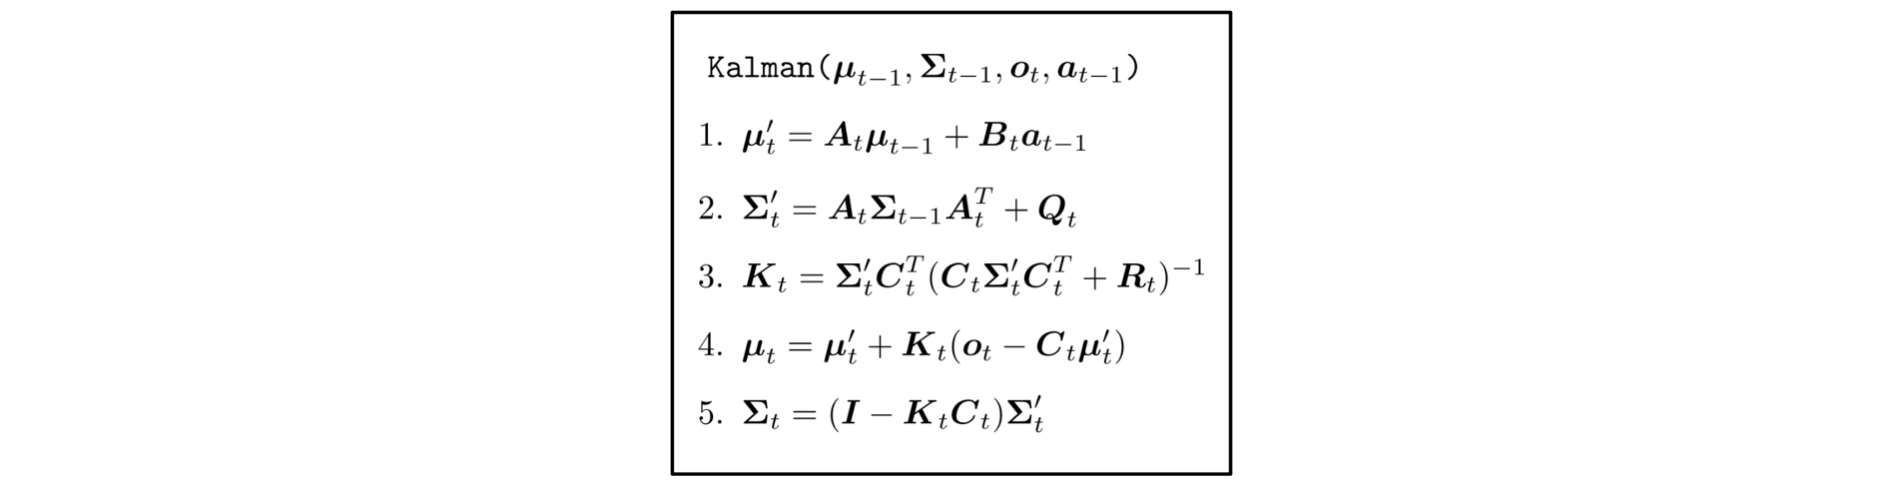

#### Prediction Step:
- Predict Next State: q represents Mu. Using Equation
            
            q = A . q + B . a

- Covariance Update: Update the covariance matrix to reflect the new predicted state and associated uncertainties: 
            
            state_covariance = A . state_covariance . A^T + Q

#### Update Step:
- Compute Kalman Gain: How much the measurements affect the prediction
            
            K = state_covariance . C^T . inverse(C . state_covariance . C^T + R)

- y represents the difference between the actual observation(measurement) o and the predicted observation(based on current state) q. C is the observation transformation matrix.
            
            y = o - C . q

- State Update: The higher the K, the more measurement affects the state update. Updating state as state + measurement residual * K

            q = q + K . y 

- Covariance Update: The covariance matrix P is updated to reflect the reduction in uncertainty due to the new observation. I is the identity matrix.

            state_covariance = (I - K . C) . state_covariance

### Initial Parameters and Equations:

We take initial parameters for A, B, C and a as given in the below image:

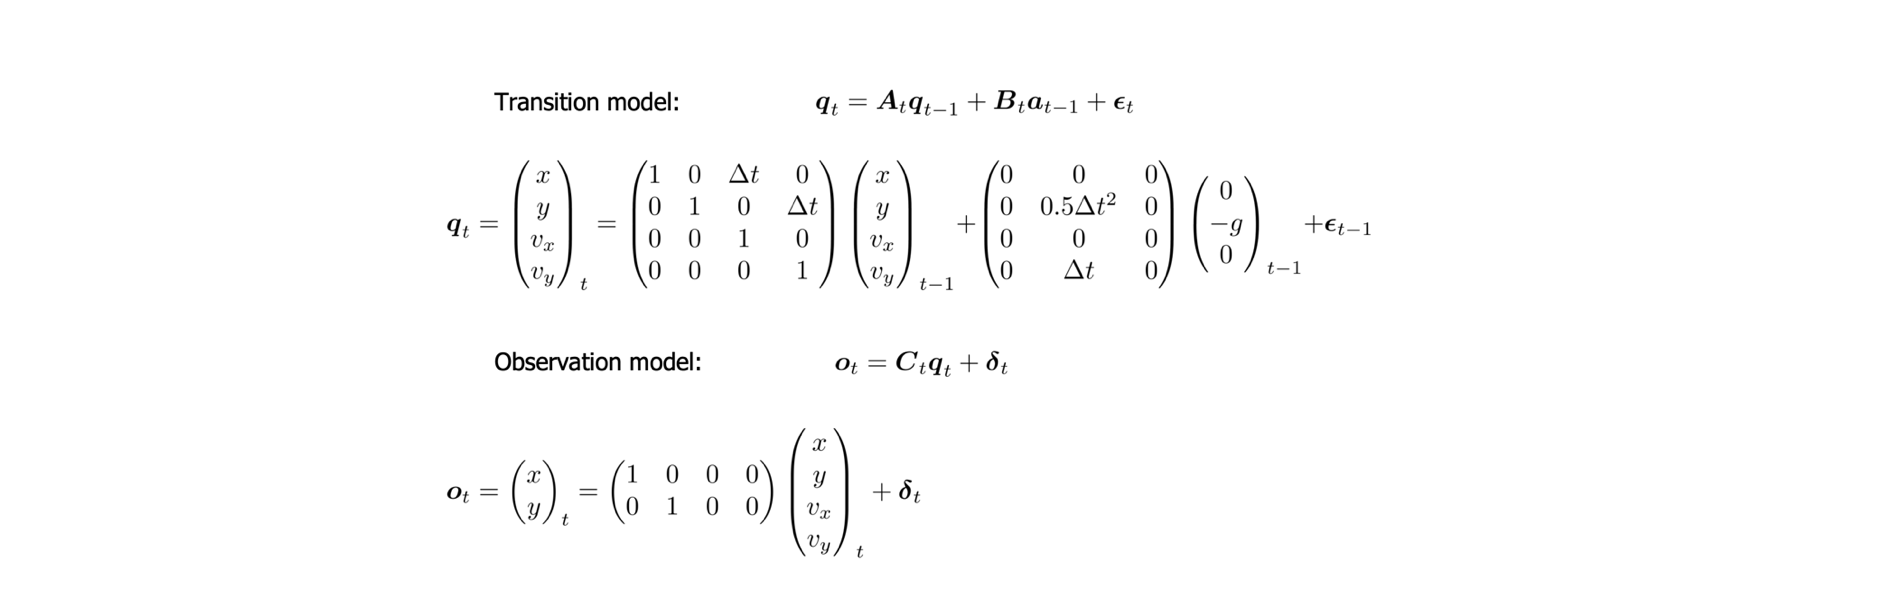

In [6]:
class KalmanFilter:
    def __init__(self, initial_position, dt, process_noise_std, observation_noise_std, Q, R):
        self.dt = dt
        self.A = np.array([                  #state transition model (transformation matrices A and B)
            [1, 0, dt, 0],
            [0, 1, 0, dt],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ])
        self.B = np.array([              
            [0, 0, 0],
            [0, 0.5 * dt**2, 0],
            [0, 0, 0],
            [0, dt, 0]
        ])
        self.a = np.array([0, -g, 0])
        self.C = np.array([                   #observation model  (transformation matrix C)
            [1, 0, 0, 0],
            [0, 1, 0, 0]
        ])
        self.Q = Q                              #prediction noise covariance (4 x 4)
        self.R = R                              #observation noise covariance (2 x 2)
        self.state_covariance = np.eye(4)       #initial estimate error covariance: Identity Matrix
        self.q = initial_position               #initial state: [x, y, vx, vy] (position and velocities)


    def predict(self):
        self.q = self.A @ self.q + self.B @ self.a                                     #predict the next state 
        self.state_covariance = self.A @ self.state_covariance @ self.A.T + self.Q     #update the covariance matrix to reflect the new state and associated uncertainties
        
    def update(self, o):
        S = self.C @ self.state_covariance @ self.C.T + self.R      #Obs_Matrix * Current_Cov_Matrix * Obs_Matrix transpose + Obs_Noise 
        K = self.state_covariance @ self.C.T @ np.linalg.inv(S)     #Kalman Gain:  How much to trust the measurement relative to prediction?
        y = o - (self.C @ self.q)                    #o:observed position(measurement) - q:predicted position
        self.q = self.q + K @ y                      #State update   
        I = np.eye(len(self.state_covariance))
        self.state_covariance = (I - K @ self.C) @ self.state_covariance      #Covariance Matrix update

    def apply_filter(self, observations):
        estimated_states = []
        for o in observations:
            if not np.isnan(o).any():
                self.update(o)           #Update if observation is valid
            self.predict()               #Predict next state based on the last available/last updated estimate
            estimated_states.append(self.q.copy())
        return np.array(estimated_states)

### Run the Kalman Filter

In [7]:
#Initial Parameters
initial_position = [0,0]                       #initial launch position
v0 = 40                                        #launch speed (m/s)
theta = 60                                     #launch angle (degrees)
dt = 0.1                                       #time step (s)
total_time = 8                                 #total simulation time (s)
observation_noise_std = 3.0                    #observation noise standard deviation (m)
process_noise_std = 1.0                        #prediction noise standard deviation (m/s^2)
Q = process_noise_std**2 * np.eye(4)           #prediction noise covariance (4 x 4) (velocity and position)
R = observation_noise_std**2 * np.eye(2)       #observation noise covariance (2 x 2)  (position)


blank_range = [(2,3),(6,6.5),(7,7.5)]          #Ranges where observations should be dropped 
dropout_probability = 1                        #Probability of the dropout inside the range

#Simulate true trajectory
time_points, true_positions = simulate_trajectory(initial_position, v0, theta, dt, total_time)
true_trajectory = np.hstack((time_points[:, np.newaxis], true_positions))

#Simulate Observations
observed_t, observed_positions = simulate_observations(true_trajectory, observation_noise_std, dropout_probability, blank_range)

#initial_state  [x,y,vx,vy]
initial_state = [initial_position[0],initial_position[1],v0 * np.cos(np.radians(theta)),v0 * np.sin(np.radians(theta))]

#Initialize the Kalman Filter
kf = KalmanFilter(initial_state, dt, process_noise_std, observation_noise_std, Q, R)

#Apply the Kalman Filter to the observations
estimated_states = kf.apply_filter(observed_positions)

In [8]:
kf.R

array([[9., 0.],
       [0., 9.]])

In [9]:
kf.Q

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [10]:
#Positions and velocities
positions = estimated_states[:, :2]  # [x, y]
velocities = estimated_states[:, 2:]  # [vx, vy]

print("Positions:\n", positions[0])
print("Velocities:\n", velocities[0])

Positions:
 [2.35379319 3.27835194]
Velocities:
 [20.         33.66001615]


### Plot Results

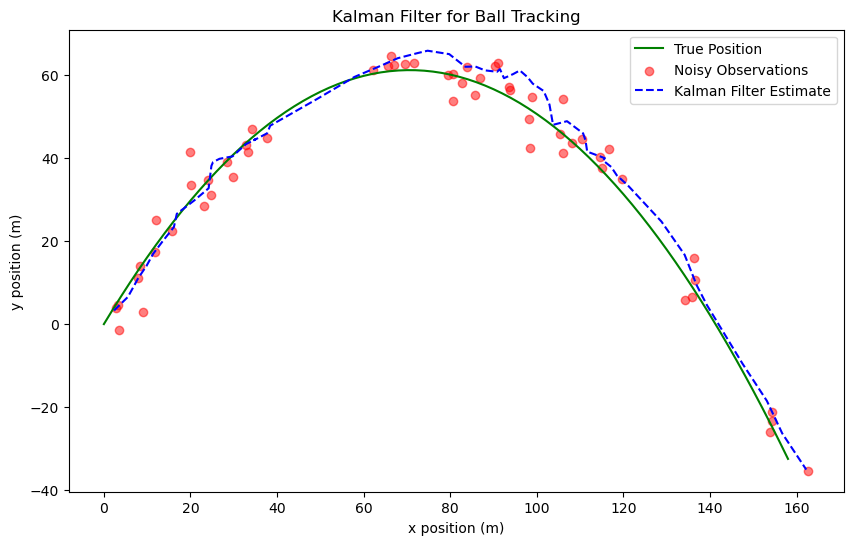

In [11]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(true_positions[:, 0], true_positions[:, 1], label='True Position', color='green')
plt.scatter(observed_positions[:, 0], observed_positions[:, 1], label='Noisy Observations', color='red', alpha=0.5)
plt.plot(estimated_states[:, 0], estimated_states[:, 1], label='Kalman Filter Estimate', color='blue', linestyle='--')
plt.xlabel('x position (m)')
plt.ylabel('y position (m)')
plt.legend()
plt.title('Kalman Filter for Ball Tracking')
plt.show()

### Plot Dropout Areas

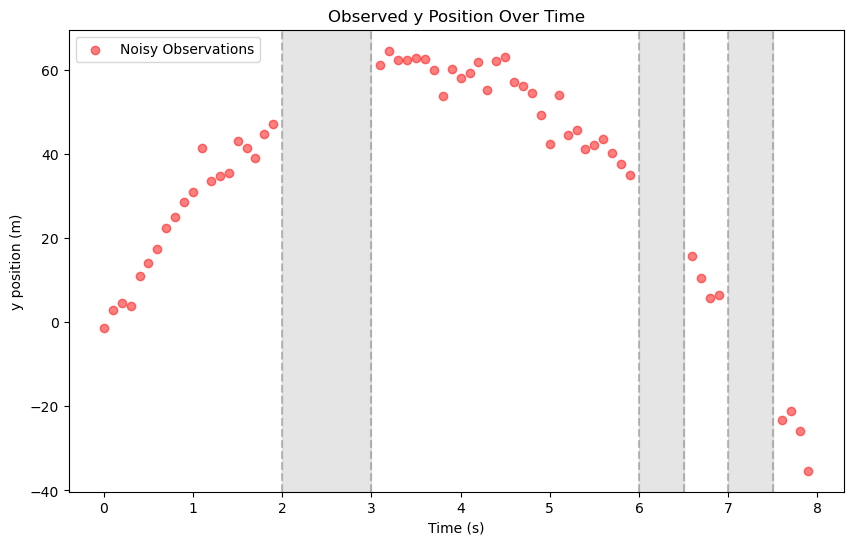

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(observed_t, observed_positions[:, 1], label='Noisy Observations', color='red', alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('y position (m)')
plt.legend()
plt.title('Observed y Position Over Time')

# Highlight the blank ranges
for start, end in blank_range:
    plt.axvline(x=start, color='gray', linestyle='--', alpha=0.5)  # Vertical line at the start of the blank range
    plt.axvline(x=end, color='gray', linestyle='--', alpha=0.5)    # Vertical line at the end of the blank range
    plt.axvspan(start, end, color='gray', alpha=0.2)  # Gray shaded area between start and end of the blank range

plt.show()

## B] Particle Filter for Parabolic Throw of 2 balls

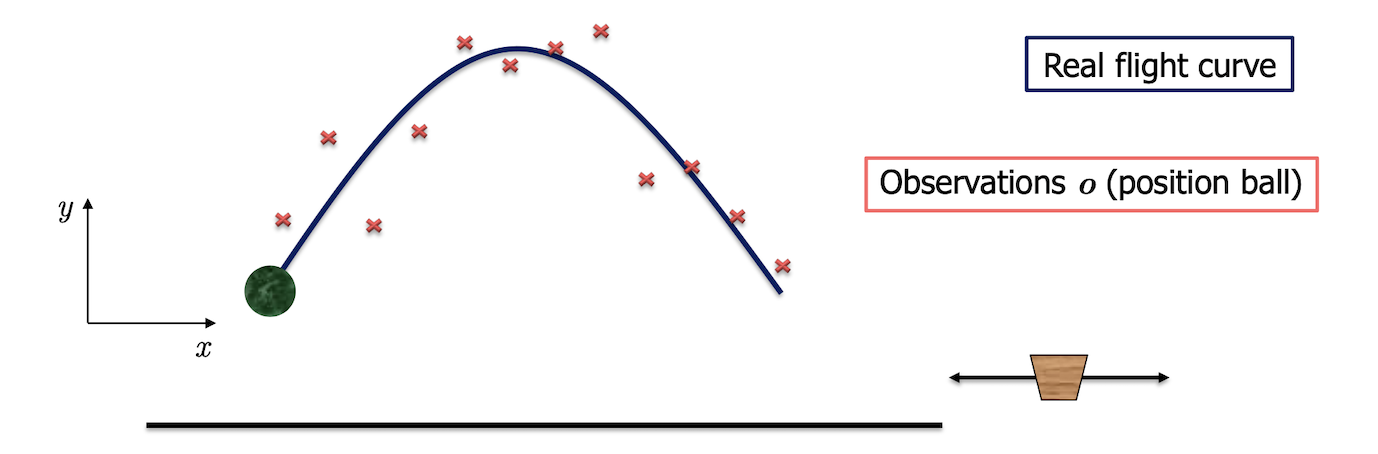

Task: Estimate the positions and velocity vectors of two balls flying simultaneously only from the
observed erroneous positions over time.

### True Trajectory:

This function calculates the true trajectory of the balls.

Function Parameters:
- initial_position1,initial_position2: [x1,y1] and [x2,y2] co-ordinates of 2 balls initial positions
- v1, v2 (float): launch speeds (m/s)
- theta1, theta2 (float): launch angles (radians)
- dt (float): time step (s)
- g (float): Gravitational constant
- total_time (float): total simulation time (s)
    
Returns:
- t (np.ndarray): time steps
- true_positions (np.ndarray): true positions (x1, y1, x2, y2)

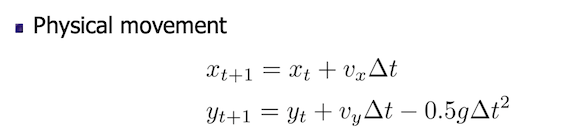

In [13]:
def simulate_pf_trajectory(initial_position1, initial_position2, v1, v2, theta1, theta2, dt, g, total_time):
    
    num_steps = int(total_time / dt)
    trajectory = np.zeros((num_steps, 8))
    time_steps = []
    
    #Velocities
    vx_1 = v1 * np.cos(np.radians(theta1))
    vy_1 = v1 * np.sin(np.radians(theta1))
    vx_2 = v2 * np.cos(np.radians(theta2))
    vy_2 = v2 * np.sin(np.radians(theta2))
    
    x1, y1, vx1, vy1, x2, y2, vx2, vy2 = initial_position1[0], initial_position1[1], vx_1, vy_1, initial_position2[0], initial_position2[1], vx_2, vy_2
    
    for t in range(num_steps):
        time_steps.append(t*dt)
        trajectory[t] = [x1, y1, vx1, vy1, x2, y2, vx2, vy2]    
        x1 = x1 + vx1 * dt
        y1 = y1 + vy1 * dt - 0.5 * g * dt ** 2
        vy1 = vy1 - g * dt
        x2 = x2 + vx2 * dt
        y2 = y2 + vy2 * dt - 0.5 * g * dt ** 2
        vy2 = vy2 - g * dt
        
    return np.array(time_steps), trajectory

### Simulate Observations:

This function simulates the sensor observations to be used in Kalman Filter for finding estimates.

Parameters:
- true_trajectory (np.ndarray): true positions (x1, y1, x2, y2)
- observation_noise_std (float): standard deviation of the observation noise
- blank_ranges (numply list) : List of time ranges where the observations need to be dropped out
- dropout_probability (float): fraction of observations that are dropped out from the given ranges
    
Returns:
- observed_time_points (np.ndarray): Time points where observations are made
- observed_positions (np.ndarray): observed positions with noise

In [14]:
def simulate_pf_observations(true_trajectory, observation_noise_std, dropout_probability, blank_ranges):
 
    time_points = true_trajectory[:, 0]    #time steps

    #Simulate dropouts and apply blank ranges
    observed_time_points = []
    for t in time_points:
        in_blank_range = any(start <= t <= end for start, end in blank_ranges)
        if in_blank_range and np.random.uniform(0, 1) < dropout_probability:            
            continue                    #Observation dropped within blank range                
        observed_time_points.append(t)  #Observation kept (outside blank range)   
    observed_time_points = np.array(observed_time_points)

    #Get true positions
    observed_indices = [np.where(time_points == t)[0][0] for t in observed_time_points]
    true_positions_ball1 = true_trajectory[observed_indices, 1:3] 
    true_positions_ball2 = true_trajectory[observed_indices, 5:7]  
    true_positions = np.concatenate((true_positions_ball1, true_positions_ball2), axis=1)

    #Add noise
    noise = np.random.normal(0, observation_noise_std, true_positions.shape)
    observed_positions = true_positions + noise

    return observed_time_points, observed_positions

### Notaitions:

- **initial_state for initial state: q=[x1,y1,x2,y2,vx1,vx2,vy1,vy2]**

- **inital_position1, initial_position2**: Initial positions for the ball1 and ball2.

- **The covariance matrix state_covariance:** Represents the uncertainty in the estimate of the state. Each element of the matrix represents the covariance between different elements of the state vector. Represents sigma.

- **The prediction noise covariance matrix Q(epsilon):** represents the uncertainty in the process model. Co-variance matrix for epsilon. Q is (8 x 8)

- **The observation noise covariance matrix R(delta):** represents the uncertainty in the observation model. Co-variance matrix for delta. R is (4 x 4) since we are not assumming noise in vx, vy, we are assumming only for x and y.

### Particle Filter Class:

- Step1: We initialize the particles randomly
- Repeat -> Step2: We sample new particles from old particle set
- Step3: **Propoagation through transition model**: We do this by applying motion to the particles, ie we apply physical movement formula to all particle positions and velocities. We add process noise to the particles as well.
- Step4: **Evaluation through observation model**: Here we get the sensor observations, and we calculate their distance from estimated values. Then we multiply the old weights with the Gaussian formula using the distances, mean zero and observation noise covariance matrix R.
- We normaize the weights, and if effective particles are less than half of the old particles, we do the resampling.
- Repeat from Step 2

#### Particle Filter Algorthim

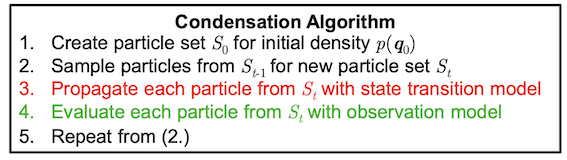

In [15]:
class ParticleFilter:
    def __init__(self, num_particles, initial_state, state_covariance, Q, R, dt, g):
        self.num_particles = num_particles
        self.particles = np.random.multivariate_normal(initial_state, state_covariance, num_particles)
        self.weights = np.ones(num_particles) / num_particles
        self.state_covariance = state_covariance
        self.Q = Q
        self.R = R
        self.dt = dt
        self.g = g

        
    #For updating weights    
    def gaussian_formula(self, x, mu, sigma):
        return np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / np.sqrt(2 * np.pi * sigma ** 2)
    
    
    #Weighted Average
    def estimate(self):
        return np.average(self.particles, weights=self.weights, axis=0)    
    

    #Step 3: Propagate through transition model: Apply physical movement and update particles    
    def predict(self):                
        for i in range(self.num_particles):            
            x1, y1, vx1, vy1, x2, y2, vx2, vy2 = self.particles[i]            
            #Apply physical movement formulas
            x1 = x1 + vx1 * self.dt
            y1 = y1 + vy1 * self.dt - 0.5 * self.g * self.dt ** 2
            vy1 = vy1 - self.g * self.dt            
            x2 = x2 + vx2 * self.dt
            y2 = y2 + vy2 * self.dt - 0.5 * self.g * self.dt ** 2
            vy2 = vy2 - self.g * self.dt            
            self.particles[i] = [x1, y1, vx1, vy1, x2, y2, vx2, vy2]            
        #adding process noise
        self.particles += np.random.multivariate_normal(np.zeros(8), self.Q, self.num_particles)
        

    #Step 4: Evaluate particles with observation model: Calculate weights and resample    
    def update(self, observed_sensor_positions):               
        if not np.isnan(observed_sensor_positions).any():
            
            #Distance from observations
            distances = np.linalg.norm(self.particles[:, [0,1,4,5]] - observed_sensor_positions, axis=1)  
            self.weights = self.weights * self.gaussian_formula(distances, 0, self.R[0, 0])

            self.weights = self.weights / sum(self.weights)                #Normalize
            effective_particles = 1.0 / np.sum(self.weights ** 2)          #Get effective particles 
            threshold = self.num_particles / 2                             #Threshold for Resampling
            if effective_particles < threshold:
                self.resample()

   
    #Step 2: Resample
    def resample(self):
        #Do sampling from multinomial distribution based on weights
        #Particles with higher weights have a higher probability to get sampled
        indices = np.random.choice(self.num_particles, self.num_particles, p=self.weights)
        self.particles = self.particles[indices]
        self.weights.fill(1.0 / self.num_particles)
        

### Set all Initial Parameters

In [28]:
#Parameters
initial_position1 = [0,0]                      #initial launch position ball 1
initial_position2 = [0,0]                      #initial launch position ball 2
v1 = 35                                        #launch speed (m/s) ball 1
v2 = 30                                        #launch speed (m/s) ball 1
theta1 = 45                                    #launch angle (degrees) ball 1
theta2 = 45                                    #launch angle (degrees) ball 2
dt = 0.1                                       #time step (s)
total_time = 8                                 #total simulation time (s)
observation_noise_std = 3.0                    #observation noise standard deviation (m)
process_noise_std = 1.0                        #prediction noise standard deviation (m/s^2)
state_covariance = np.eye(8)                   #state covariance matrix (8 x 8)
Q = process_noise_std**2 * np.eye(8)           #prediction noise covariance (4 x 4)
R = observation_noise_std**2 * np.eye(4)       #observation noise covariance (2 x 2)
num_particles = 1000                           #num(particles) for Particle Filter


blank_range = [(2,3),(6,6.5),(7,7.5)]          #Ranges where observations should be dropped 
dropout_probability = 1                        #Probability of the dropout inside the range

#State Vector [x1, y1, vx1, vy1, x2, y2, vx2, vy2]
initial_state = [initial_position1[0], initial_position1[1], v1 * np.cos(np.radians(theta1)), v1 * np.sin(np.radians(theta1)), initial_position2[0], initial_position2[1], v2 * np.cos(np.radians(theta2)), v2 * np.sin(np.radians(theta2))]  

#Simulate true trajectory
time_points, true_positions = simulate_pf_trajectory(initial_position1, initial_position2, v1, v2, theta1, theta2, dt, g, total_time)
true_trajectory = np.hstack((time_points[:, np.newaxis], true_positions))

#Simulate Observations
observed_t, observed_positions = simulate_pf_observations(true_trajectory, observation_noise_std, dropout_probability, blank_range)

### Run Particle Filter

In [29]:
pf = ParticleFilter(num_particles, initial_state, state_covariance, Q, R, dt, g)

#Run PF
estimates = np.zeros((len(observed_t), 8))
for t in range(len(observed_t)):
    pf.predict()                          #predict step
    pf.update(observed_positions[t])      #update step
    estimates[t] = pf.estimate()  

In [30]:
pf.Q

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [31]:
pf.R

array([[9., 0., 0., 0.],
       [0., 9., 0., 0.],
       [0., 0., 9., 0.],
       [0., 0., 0., 9.]])

### Plot True and Predicted Results

In [32]:
# Extract positions and velocities
positions = estimates[:, :4]   #[x1, y1, x2, y2]
velocities = estimates[:, 4:]  #[vx1, vy1, vx2, vy2]

print("Positions:\n", positions[0])
print("Velocities:\n", velocities[0])

Positions:
 [ 2.41617424  2.46910128 24.75551806 23.84254105]
Velocities:
 [ 2.11168858  2.01465744 21.1414596  20.17924745]


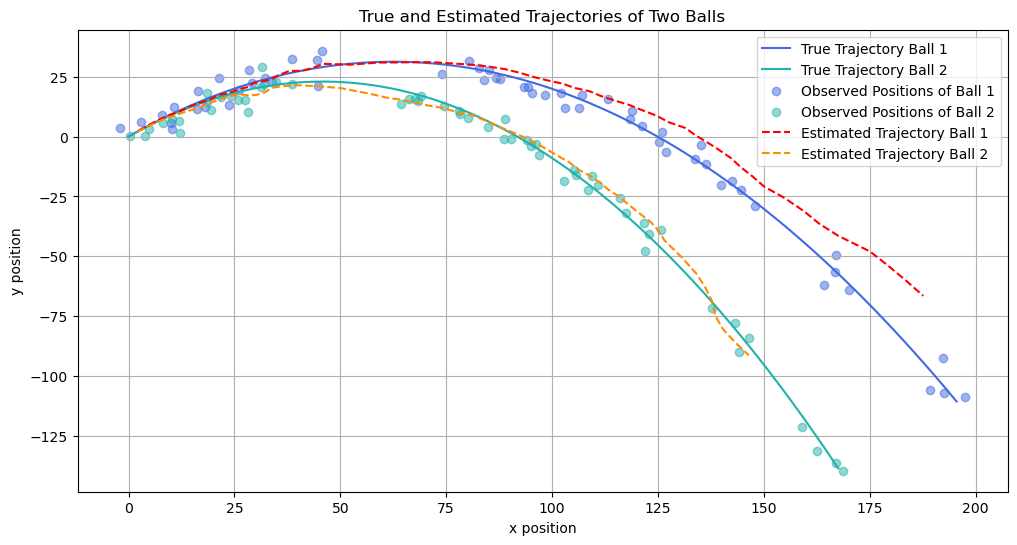

In [33]:
plt.figure(figsize=(12, 6))

plt.plot(true_positions[:, 0], true_positions[:, 1], label='True Trajectory Ball 1', color='royalblue')
plt.plot(true_positions[:, 4], true_positions[:, 5], label='True Trajectory Ball 2', color='lightseagreen')
plt.scatter(observed_positions[:, 0], observed_positions[:, 1], label='Observed Positions of Ball 1', color='royalblue', alpha=0.5)
plt.scatter(observed_positions[:, 2], observed_positions[:, 3], label='Observed Positions of Ball 2', color='lightseagreen', alpha=0.5)
plt.plot(estimates[:, 0], estimates[:, 1], label='Estimated Trajectory Ball 1', color='red', linestyle='--')
plt.plot(estimates[:, 4], estimates[:, 5], label='Estimated Trajectory Ball 2', color='darkorange', linestyle='--')

plt.xlabel('x position')
plt.ylabel('y position')
plt.title('True and Estimated Trajectories of Two Balls')
plt.legend()
plt.grid(True)
plt.show()

### Plot Dropout Areas

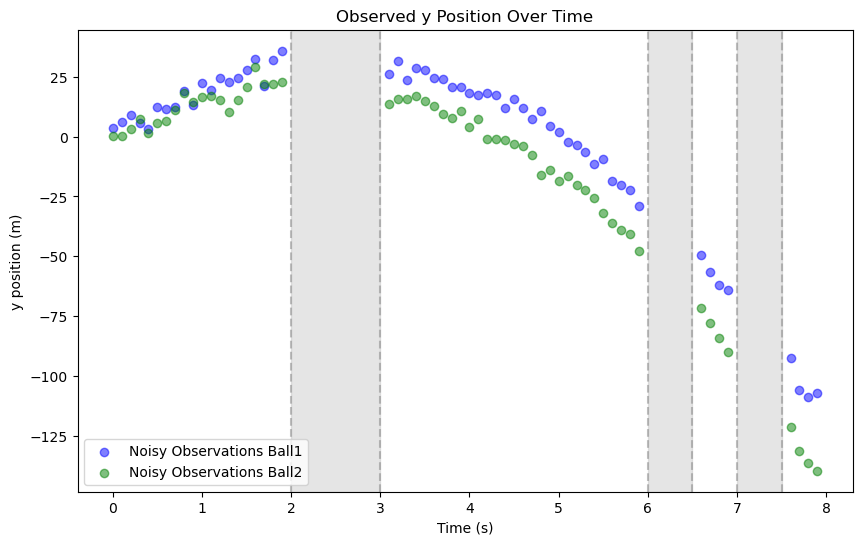

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(observed_t, observed_positions[:, 1], label='Noisy Observations Ball1', color='blue', alpha=0.5)
plt.scatter(observed_t, observed_positions[:, 3], label='Noisy Observations Ball2', color='green', alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('y position (m)')
plt.legend()
plt.title('Observed y Position Over Time')

# Highlight the blank ranges
for start, end in blank_range:
    plt.axvline(x=start, color='gray', linestyle='--', alpha=0.5)  #Vertical line: start of the blank range
    plt.axvline(x=end, color='gray', linestyle='--', alpha=0.5)    #Vertical line: end of the blank range
    plt.axvspan(start, end, color='gray', alpha=0.2)  #Gray shaded area: blank range

plt.show()